# 1. Setup and Data Preparation

### 1.1  Install Dependencies and Setup

In [1]:
import os
import shutil
import random

import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_curve, classification_report, confusion_matrix

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.constraints import MaxNorm
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

2023-03-28 21:00:20.687608: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
device_name = tf.test.gpu_device_name()
if len(device_name) > 0:
    print("Found GPU at: {}".format(device_name))
else:
    device_name = "/device:CPU:0"
    print("No GPU, using {}.".format(device_name))
    
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

Found GPU at: /device:GPU:0
Metal device set to: Apple M1


2023-03-28 21:00:24.298364: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-28 21:00:24.298868: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-28 21:00:24.298900: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### 1.2 Prepare Data
#### 1.2.1 Make up Directory paths

In [3]:
seed = 1
random.seed(seed)

directory = "/Users/pakpoom.danjittisiri/Documents/M.Sc. Classes/Progamming/[msc_class] modern_machine_learning/Convolutional Neural Network (CNN)/Data/"

# Directory for the location of each train, val and test folder
train_dir = os.path.join(directory, "train/")
val_dir = os.path.join(directory, "val/")
test_dir = os.path.join(directory, "test/")

# Directory for the location of label.txt files 
train_label_dir = os.path.join(directory, "trainlabels.txt")
val_label_dir = os.path.join(directory, "vallabels.txt")
test_label_dir = os.path.join(directory, "testlabels.txt")

# Lists contained variables for futher operations
dir_names = ["train", "validation", "test"]
data_dirs = [train_dir, val_dir, test_dir]
label_dirs = [train_label_dir, val_label_dir, test_label_dir]

#### 1.2.2 Create categorical forders containing benign and malignant images separately in each train, val and test forder

In [4]:
"""from tqdm import tqdm
from time import sleep

for data_ind, data_dir in enumerate(data_dirs):
    os.makedirs(data_dir + "benign/")
    os.makedirs(data_dir + "malignant/")

# Categorize image data into its belonging folders
examples = 0
for label_ind, label_dir in enumerate(label_dirs):
    for line in tqdm(open(label_dir).readlines()[1:]):
        split_line = line.split(" ")
        img_file_1 = split_line[0].split("/")
        img_file_2 = img_file_1[1]
        benign_malign = split_line[1]
        if int(float(benign_malign)) == 0:
            if os.path.exists(data_dirs[label_ind] + img_file_2):
                shutil.copy(
                    data_dirs[label_ind] + img_file_2,
                    data_dirs[label_ind] + "benign/" + img_file_2
                )
                examples += 1
        elif int(float(benign_malign)) == 1:
            if os.path.exists(data_dirs[label_ind] + img_file_2):
                shutil.copy(
                    data_dirs[label_ind] + img_file_2,
                    data_dirs[label_ind] + "malignant/" + img_file_2
                )
                examples += 1
    print(f"Number of {dir_names[label_ind]} examples: {examples}")
    examples = 0"""

'from tqdm import tqdm\nfrom time import sleep\n\nfor data_ind, data_dir in enumerate(data_dirs):\n    os.makedirs(data_dir + "benign/")\n    os.makedirs(data_dir + "malignant/")\n\n# Categorize image data into its belonging folders\nexamples = 0\nfor label_ind, label_dir in enumerate(label_dirs):\n    for line in tqdm(open(label_dir).readlines()[1:]):\n        split_line = line.split(" ")\n        img_file_1 = split_line[0].split("/")\n        img_file_2 = img_file_1[1]\n        benign_malign = split_line[1]\n        if int(float(benign_malign)) == 0:\n            if os.path.exists(data_dirs[label_ind] + img_file_2):\n                shutil.copy(\n                    data_dirs[label_ind] + img_file_2,\n                    data_dirs[label_ind] + "benign/" + img_file_2\n                )\n                examples += 1\n        elif int(float(benign_malign)) == 1:\n            if os.path.exists(data_dirs[label_ind] + img_file_2):\n                shutil.copy(\n                    data_di

# 2. Data Preprocessing
### 2.1 Data Normailization and Augmentation

In [5]:
image_gen_train = ImageDataGenerator(
    rescale = 1.0/255,
    rotation_range = 15,
    zoom_range = (0.95, 0.95),
    horizontal_flip = True,
    vertical_flip = True,
    data_format = "channels_last"
)
image_gen_val = ImageDataGenerator(rescale = 1.0/255)
image_gen_test = ImageDataGenerator(rescale = 1.0/255)

### 2.2 Load Data

In [6]:
train_examples = 5187
validation_examples = 1297
test_examples = 1622
img_height = img_width = 224
batch_size = 32

train_data_gen = image_gen_train.flow_from_directory(
    directory = train_dir,
    target_size = (img_height, img_width),
    batch_size = batch_size,
    color_mode = "rgb",
    class_mode = "binary",
    shuffle = True,
    seed = seed
)

val_data_gen = image_gen_val.flow_from_directory(
    directory = val_dir,
    target_size = (img_height, img_width),
    batch_size = batch_size,
    color_mode = "rgb",
    class_mode = "binary",
    shuffle = True,
    seed = seed
)

test_data_gen = image_gen_test.flow_from_directory(
    directory = test_dir,
    target_size = (img_height, img_width),
    batch_size = batch_size,
    color_mode = "rgb",
    class_mode = "binary",
    shuffle = False,
    seed = seed
)

Found 5187 images belonging to 2 classes.
Found 1297 images belonging to 2 classes.
Found 1622 images belonging to 2 classes.


# 3. Deep Model and Performance
### 3.1 Build Deep Learning Model

In [7]:
with tf.device(device_name):
    
    model = Sequential()
    
    model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(224, 224, 3)))
    model.add(MaxPooling2D())
    model.add(Conv2D(32, (3,3), 1, activation='relu'))
    model.add(MaxPooling2D())
    model.add(Conv2D(16, (3,3), 1, activation='relu'))
    model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(Dense(256, activation='relu', kernel_constraint=MaxNorm(3)))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu', kernel_constraint=MaxNorm(3)))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    
    METRICS = [
        keras.metrics.BinaryAccuracy(name="accuracy"),
        keras.metrics.Precision(name="precision"),
        keras.metrics.Recall(name="recall"),
        keras.metrics.AUC(name="auc")
    ]
    
    model.compile(
        loss=[keras.losses.BinaryCrossentropy(from_logits=False)], 
        optimizer=keras.optimizers.Adam(learning_rate=3e-4), 
        metrics=METRICS
    )
    
    model.summary()

2023-03-28 21:00:24.568378: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-28 21:00:24.568404: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 16)       0

### 3.2 Train

In [8]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")

epochs = 10

In [9]:
hist = model.fit(
    train_data_gen,
    epochs = epochs,
    steps_per_epoch = train_examples//batch_size,
    validation_data = val_data_gen,
    validation_steps = validation_examples//batch_size,
    callbacks = [tensorboard_callback]
    )

Epoch 1/10


2023-03-28 21:00:26.100241: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


162/162 [==============================] - ETA: 0s - loss: 0.4489 - accuracy: 0.8359 - precision: 0.4655 - recall: 0.0321 - auc: 0.6032

2023-03-28 21:01:26.608255: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


162/162 [==============================] - 64s 381ms/step - loss: 0.4489 - accuracy: 0.8359 - precision: 0.4655 - recall: 0.0321 - auc: 0.6032 - val_loss: 0.4072 - val_accuracy: 0.8273 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7644
Epoch 2/10
162/162 [==============================] - 86s 531ms/step - loss: 0.3771 - accuracy: 0.8454 - precision: 0.6056 - recall: 0.1305 - auc: 0.7695 - val_loss: 0.3760 - val_accuracy: 0.8406 - val_precision: 0.7250 - val_recall: 0.1306 - val_auc: 0.7926
Epoch 3/10
162/162 [==============================] - 86s 531ms/step - loss: 0.3547 - accuracy: 0.8483 - precision: 0.5960 - recall: 0.2143 - auc: 0.8095 - val_loss: 0.3615 - val_accuracy: 0.8461 - val_precision: 0.8788 - val_recall: 0.1306 - val_auc: 0.8426
Epoch 4/10
162/162 [==============================] - 86s 531ms/step - loss: 0.3345 - accuracy: 0.8555 - precision: 0.6505 - recall: 0.2536 - auc: 0.8394 - val_loss: 0.3430 - val_accuracy: 0.8445 - val_precision: 0.6909 - val_

### 3.3 Loss Visualization

In [10]:
def visualize_loss(hist):
    fig = plt.figure(figsize=(5,3))
    plt.plot(hist.history['loss'], color='teal', label='loss')
    plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")
    plt.show()

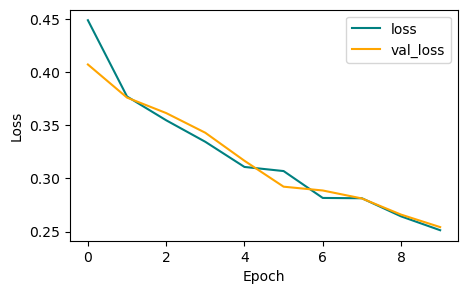

In [11]:
visualize_loss(hist)

### 3.4 Evaluate

In [12]:
score = model.evaluate(test_data_gen, verbose=2)

print('\nTest loss:', "{:.4f}".format(score[0])) 
print('Test accuracy:', "{:.4f}".format(score[1]))
print('Test F1 score:', "{:.4f}".format(2*((score[2]*score[3])/(score[2]+score[3]+K.epsilon()))))

51/51 - 3s - loss: 0.2462 - accuracy: 0.9020 - precision: 0.8090 - recall: 0.5709 - auc: 0.9246 - 3s/epoch - 54ms/step

Test loss: 0.2462
Test accuracy: 0.9020
Test F1 score: 0.6694


### 3.5 Test 

In [13]:
def create_tst_lb(test_data_gen):

    test_labels = np.array([])
    num_batches = 0
    for _, y in test_data_gen:
        test_labels = np.append(test_labels, y)
        num_batches += 1 
        if num_batches == math.ceil(test_examples / batch_size):
            break
    
    return test_labels

In [14]:
def plot_roc(labels, predictions):
    fp, tp, _ = roc_curve(labels, predictions)
    plt.plot(100*fp, 100*tp)
    plt.suptitle('ROC curve', fontsize=15)
    plt.xlabel("Flase positive [%]")
    plt.ylabel("Tru positive [%]")
    plt.show()

 4/51 [=>............................] - ETA: 1s 

2023-03-28 21:14:27.974261: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


51/51 [==============================] - 2s 41ms/step


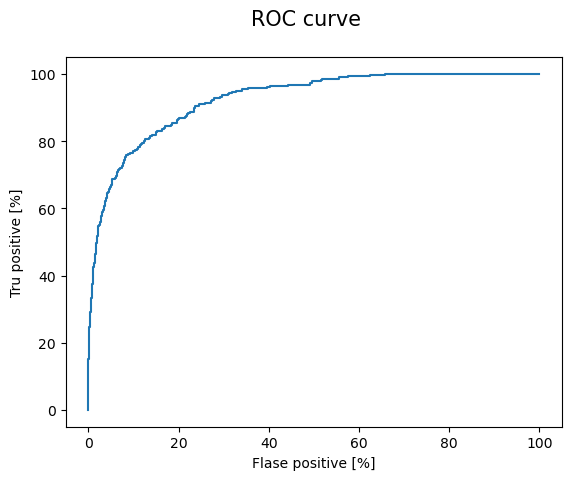


Confusion Matrix:
 [[1302   38]
 [ 121  161]]

Classification Report:
               precision    recall  f1-score   support

      benign       0.91      0.97      0.94      1340
   malignant       0.81      0.57      0.67       282

    accuracy                           0.90      1622
   macro avg       0.86      0.77      0.81      1622
weighted avg       0.90      0.90      0.89      1622



In [15]:
pred_prob = model.predict(test_data_gen)
predictions = pred_prob > 0.5

test_labels = create_tst_lb(test_data_gen)
plot_roc(test_labels, pred_prob)

cm = confusion_matrix(y_true=test_data_gen.classes, y_pred=predictions)
class_report = classification_report(test_data_gen.classes, predictions, target_names=["benign", "malignant"])
print('\nConfusion Matrix:\n', cm)
print('\nClassification Report:\n', class_report)

# 4. Transfer Learning Application
### 4.1 Build Transfer Learning Model 

In [16]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

In [17]:
with tf.device(device_name):

    vgg = VGG16(
        input_shape = (224,224,3), 
        weights = "imagenet", 
        include_top = False
    )

    for layer in vgg.layers:
        layer.trainable = False

    x = Flatten()(vgg.output)
    x = Dense(256, activation = "relu", kernel_constraint=MaxNorm(3))(x)  
    x = Dropout(0.5)(x)
    x = Dense(64, activation = "relu", kernel_constraint=MaxNorm(3))(x)
    x = Dropout(0.2)(x)
    x = Dense(1, activation = "sigmoid")(x) 

    vgg_model = Model(
        inputs = vgg.input, 
        outputs = x
    )

    METRICS = [
        keras.metrics.BinaryAccuracy(name="accuracy"),
        keras.metrics.Precision(name="precision"),
        keras.metrics.Recall(name="recall"),
        keras.metrics.AUC(name="auc")
    ]
    
    vgg_model.compile(
        loss = [keras.losses.BinaryCrossentropy(from_logits=False)], 
        optimizer = keras.optimizers.Adam(learning_rate=3e-4), 
        metrics = METRICS
    )

    print(vgg_model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### 4.2 Train

In [18]:
hist = vgg_model.fit(
    train_data_gen,
    epochs = epochs,
    steps_per_epoch = train_examples//batch_size,
    validation_data = val_data_gen,
    validation_steps = validation_examples//batch_size,
    callbacks = [tensorboard_callback],
    verbose=1
    )

Epoch 1/10


2023-03-28 21:14:33.498135: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


162/162 [==============================] - ETA: 0s - loss: 0.4724 - accuracy: 0.8277 - precision: 0.2553 - recall: 0.0285 - auc: 0.5667

2023-03-28 21:18:06.062646: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


162/162 [==============================] - 256s 2s/step - loss: 0.4724 - accuracy: 0.8277 - precision: 0.2553 - recall: 0.0285 - auc: 0.5667 - val_loss: 0.4261 - val_accuracy: 0.8281 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7467
Epoch 2/10
162/162 [==============================] - 257s 2s/step - loss: 0.4218 - accuracy: 0.8359 - precision: 0.4603 - recall: 0.0345 - auc: 0.6729 - val_loss: 0.4141 - val_accuracy: 0.8273 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7949
Epoch 3/10
162/162 [==============================] - 259s 2s/step - loss: 0.3966 - accuracy: 0.8442 - precision: 0.6336 - recall: 0.0990 - auc: 0.7251 - val_loss: 0.3913 - val_accuracy: 0.8367 - val_precision: 0.8500 - val_recall: 0.0762 - val_auc: 0.8223
Epoch 4/10
162/162 [==============================] - 257s 2s/step - loss: 0.3605 - accuracy: 0.8502 - precision: 0.6402 - recall: 0.1824 - auc: 0.7988 - val_loss: 0.3616 - val_accuracy: 0.8391 - val_precision: 0.8636 - val_

### 4.3 Loss Visualization

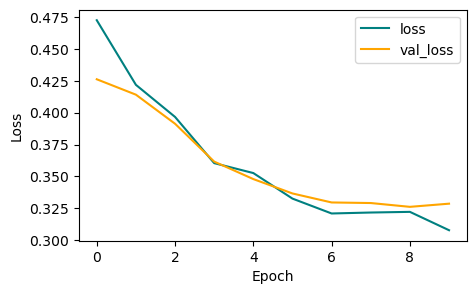

In [19]:
visualize_loss(hist)

### 4.4 Evaluate

In [20]:
score = vgg_model.evaluate(test_data_gen, verbose=2)

print('\nTest loss:', "{:.4f}".format(score[0])) 
print('Test accuracy:', "{:.4f}".format(score[1]))
print('Test F1 score:', "{:.4f}".format(2*((score[2]*score[3])/(score[2]+score[3]+K.epsilon()))))

51/51 - 58s - loss: 0.3229 - accuracy: 0.8785 - precision: 0.8295 - recall: 0.3794 - auc: 0.8866 - 58s/epoch - 1s/step

Test loss: 0.3229
Test accuracy: 0.8785
Test F1 score: 0.5207


### 4.5 Test

2023-03-28 21:58:52.678905: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


51/51 [==============================] - 50s 983ms/step


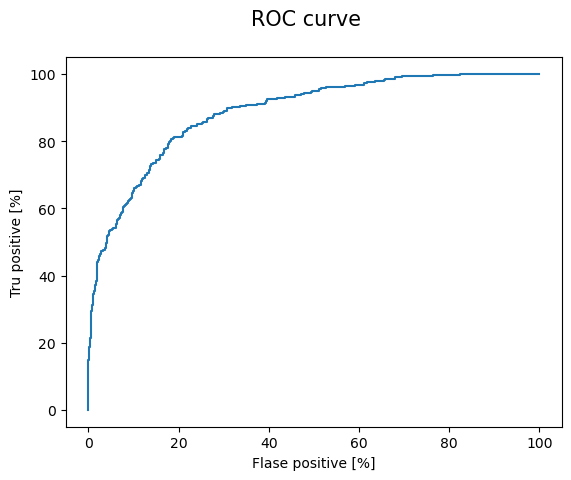


Confusion Matrix:
 [[1318   22]
 [ 175  107]]

Classification Report:
               precision    recall  f1-score   support

      benign       0.88      0.98      0.93      1340
   malignant       0.83      0.38      0.52       282

    accuracy                           0.88      1622
   macro avg       0.86      0.68      0.73      1622
weighted avg       0.87      0.88      0.86      1622



In [21]:
pred_prob = vgg_model.predict(test_data_gen)
predictions = pred_prob > 0.5

plot_roc(test_labels, pred_prob)

cm = confusion_matrix(y_true=test_data_gen.classes, y_pred=predictions)
class_report = classification_report(test_data_gen.classes, predictions, target_names=["benign", "malignant"])
print('\nConfusion Matrix:\n', cm)
print('\nClassification Report:\n', class_report)

# 5. Transfer Learning application with Fine Tuning and Performance
### 5.1 Build Transfer Learning Model with Fine Tuning

In [22]:
with tf.device(device_name):

    vgg = VGG16(
        input_shape = (224,224,3), 
        weights = "imagenet", 
        include_top = False
    )

    for layer in vgg.layers[:13]:
        layer.trainable = False

    x = Flatten()(vgg.output)
    x = Dense(256, activation = "relu", kernel_constraint=MaxNorm(3))(x)  
    x = Dropout(0.5)(x)
    x = Dense(64, activation = "relu", kernel_constraint=MaxNorm(3))(x)
    x = Dropout(0.2)(x)
    x = Dense(1, activation = "sigmoid")(x) 

    vgg_tuned_model = Model(
        inputs = vgg.input, 
        outputs = x
    )

    METRICS = [
        keras.metrics.BinaryAccuracy(name="accuracy"),
        keras.metrics.Precision(name="precision"),
        keras.metrics.Recall(name="recall"),
        keras.metrics.AUC(name="auc")
    ]
    
    vgg_tuned_model.compile(
        loss=[keras.losses.BinaryCrossentropy(from_logits=False)], 
        optimizer=keras.optimizers.Adam(learning_rate=3e-4), 
        metrics=METRICS
    )

    print(vgg_tuned_model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

### 5.2 Train

In [23]:
hist = vgg_tuned_model.fit(
    train_data_gen,
    epochs = epochs,
    steps_per_epoch = train_examples//batch_size,
    validation_data = val_data_gen,
    validation_steps = validation_examples//batch_size,
    callbacks = [tensorboard_callback],
    verbose=1
    )

Epoch 1/10


2023-03-28 21:59:45.533870: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


162/162 [==============================] - ETA: 0s - loss: 0.4601 - accuracy: 0.8345 - precision: 0.2000 - recall: 0.0048 - auc: 0.5352

2023-03-28 22:04:33.894163: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


162/162 [==============================] - 334s 2s/step - loss: 0.4601 - accuracy: 0.8345 - precision: 0.2000 - recall: 0.0048 - auc: 0.5352 - val_loss: 0.4444 - val_accuracy: 0.8266 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6432
Epoch 2/10
162/162 [==============================] - 331s 2s/step - loss: 0.3888 - accuracy: 0.8433 - precision: 0.6053 - recall: 0.1095 - auc: 0.7585 - val_loss: 0.3281 - val_accuracy: 0.8641 - val_precision: 0.6643 - val_recall: 0.4227 - val_auc: 0.8524
Epoch 3/10
162/162 [==============================] - 359s 2s/step - loss: 0.3202 - accuracy: 0.8691 - precision: 0.6473 - recall: 0.4359 - auc: 0.8537 - val_loss: 0.2685 - val_accuracy: 0.8922 - val_precision: 0.7733 - val_recall: 0.5273 - val_auc: 0.9127
Epoch 4/10
162/162 [==============================] - 330s 2s/step - loss: 0.2749 - accuracy: 0.8892 - precision: 0.7004 - recall: 0.5595 - auc: 0.8968 - val_loss: 0.2537 - val_accuracy: 0.9023 - val_precision: 0.8038 - val_recall: 

### 5.3 Loss Visualization

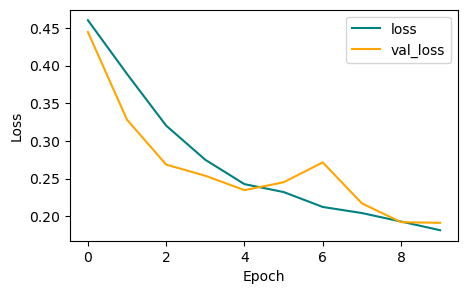

In [24]:
visualize_loss(hist)

### 5.4 Evaluate

In [25]:
score = vgg_tuned_model.evaluate(test_data_gen, verbose=2)

print('\nTest loss:', "{:.4f}".format(score[0])) 
print('Test accuracy:', "{:.4f}".format(score[1]))
print('Test F1 score:', "{:.4f}".format(2*((score[2]*score[3])/(score[2]+score[3]+K.epsilon()))))

51/51 - 59s - loss: 0.1807 - accuracy: 0.9346 - precision: 0.8793 - recall: 0.7234 - auc: 0.9657 - 59s/epoch - 1s/step

Test loss: 0.1807
Test accuracy: 0.9346
Test F1 score: 0.7938


### 5.5 Test

2023-03-28 22:57:04.791386: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


51/51 [==============================] - 52s 1s/step


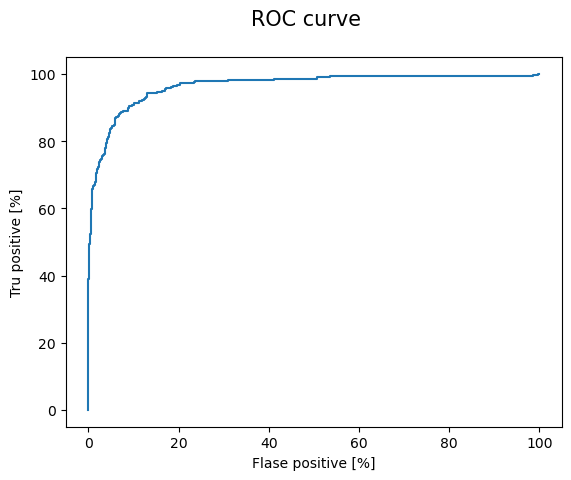


Confusion Matrix:
 [[1312   28]
 [  78  204]]

Classification Report:
               precision    recall  f1-score   support

      benign       0.94      0.98      0.96      1340
   malignant       0.88      0.72      0.79       282

    accuracy                           0.93      1622
   macro avg       0.91      0.85      0.88      1622
weighted avg       0.93      0.93      0.93      1622



In [26]:
pred_prob = vgg_tuned_model.predict(test_data_gen)
predictions = pred_prob > 0.5

plot_roc(test_labels, pred_prob)

cm = confusion_matrix(y_true=test_data_gen.classes, y_pred=predictions)
class_report = classification_report(test_data_gen.classes, predictions, target_names=["benign", "malignant"])
print('\nConfusion Matrix:\n', cm)
print('\nClassification Report:\n', class_report)